# K-Nearest Neighbors (KNN) — Churn Prediction

This notebook trains and evaluates a KNN classifier for an imbalanced
binary classification problem

Key features:
- SMOTE applied **inside cross-validation**
- Hyperparameter tuning for `n_neighbors`
- Stratified 5-fold cross-validation
- Evaluation using Precision–Recall AUC (PR-AUC)
- Saving final model predictions



In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    average_precision_score
)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


## Load Preprocessed Data

This notebook assumes that EDA and preprocessing files has already been made and
produced the following variables:

- `X_train`, `X_test`
- `y_train`, `y_test`


In [17]:

# Relative path from notebooks/models/ to data/processed/
processed_dir = Path('../../data/processed')

print("Looking for CSV files in:", processed_dir.resolve())

# Load CSVs
X_train = pd.read_csv(processed_dir / 'X_train_scaled.csv')
X_test  = pd.read_csv(processed_dir / 'X_test_scaled.csv')
y_train = pd.read_csv(processed_dir / 'y_train.csv')['churn']
y_test  = pd.read_csv(processed_dir / 'y_test.csv')['churn']

print("Data loaded successfully!")
print("Shapes:")
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)




Looking for CSV files in: C:\Users\senki\CustomerChurn\data\processed
Data loaded successfully!
Shapes:
X_train: (8000, 15)
X_test:  (2000, 15)
y_train: (8000,)
y_test: (2000,)


## Model pipeline and cross-validation

SMOTE is included inside an `imblearn` pipeline to ensure that
oversampling is applied **only to the training folds** within
cross-validation.

Hyperparameter tuning is performed using GridSearchCV with
PR-AUC (`average_precision`) as the scoring metric.


In [18]:
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV PR AUC:", grid_search.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'knn__n_neighbors': 15}
Best CV PR AUC: 0.5244266990282226


## Final evaluation on the test set

The best-performing model from cross-validation is evaluated
on the **held-out test set**, which was not used during
model selection or hyperparameter tuning.


In [19]:
best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

pr_auc = average_precision_score(y_test, y_proba)
print("Test PR AUC:", pr_auc)


              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1593
           1       0.40      0.68      0.51       407

    accuracy                           0.73      2000
   macro avg       0.65      0.71      0.66      2000
weighted avg       0.80      0.73      0.75      2000

Test PR AUC: 0.527322734664042


## Precision–Recall curve

The Precision–Recall curve provides a more informative evaluation
than ROC curves for imbalanced classification problems.



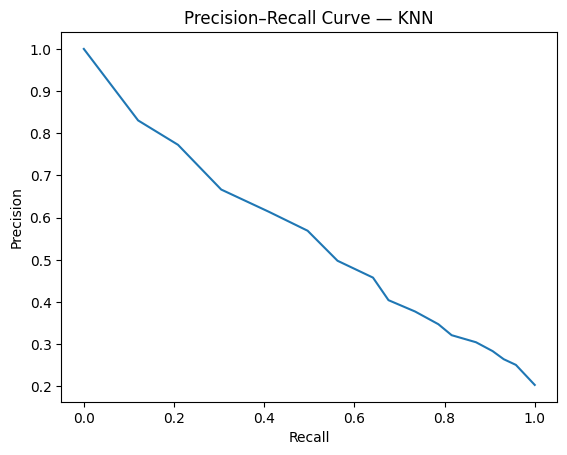

In [20]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — KNN")
plt.show()


## Save model predictions

Predictions and predicted probabilities on the test set are saved
for downstream analysis and comparison with other models.


In [21]:
results_knn = pd.DataFrame({
    'y_test': y_test.values,
    'y_pred': y_pred,
    'y_proba': y_proba
})

results_knn.to_csv(
    '../../data/processed/knn_results.csv',
    index=False
)

